### Loading GAMS magic
The **gams.magic** Python package is loaded in order to access GAMS line and cell magics

In [1]:
import gams


In [6]:
%reload_ext gams.magic

### Loading the price data
The price data is provided from a CSV file located on the web. The Python package **pandas** is used to load the data. 

In [7]:
import pandas as pd
url="https://github.com/daveh19/pydataberlin2017/raw/master/notebooks/dowjones2016.csv"
price_data=pd.read_csv(url)

In [8]:
m = gams.exchange_container
date = m.addSet('date', description='trading date')
symbol = m.addSet('symbol', description='stock symbol')
price = m.addParameter('price', [date, symbol], domain_forwarding=True, records=price_data, description='price of stock on date')
d = m.addAlias('d', date)
s = m.addAlias('s', symbol)

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


The mean price per stock is calculated in GAMS.

In [9]:
avgprice = m.addParameter('avgprice', [symbol], description='average price of stock')
%gams avgprice(s) = sum(d, price(d,s))/card(d);
avgprice.records.head()

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


,symbol,value
0,AAPL,104.604008
1,AXP,63.793333
2,BA,133.111508
3,CAT,78.698016
4,CSCO,28.789683


The averages can be used in order to calculate weights.

In [10]:
weight = m.addParameter('weight', [symbol], description='weight of stock')
%gams weight(symbol) = avgprice(symbol)/sum(s, avgprice(s));
weight.records.head()

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


,symbol,value
0,AAPL,0.039960
1,AXP,0.024370
2,BA,0.050850
3,CAT,0.030063
4,CSCO,0.010998


Compute the contributions using weight and price

In [11]:
contribution = m.addParameter('contribution', [date,symbol])
%gams contribution(d,s) = weight(s)*price(d,s);
contribution.records.head()

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


,date,symbol,value
0,2016-01-04,AAPL,4.209752
1,2016-01-04,AXP,1.647143
2,2016-01-04,BA,7.144396
3,2016-01-04,CAT,2.044007
4,2016-01-04,CSCO,0.290455


Compute index values

In [12]:
index = m.addParameter('index', [date], description='Dow Jones index')
%gams index(d) = sum(s, contribution(d,s));
index.records.head()

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


,date,value
0,2016-01-04,100.572929
1,2016-01-05,100.511422
2,2016-01-06,99.014207
3,2016-01-07,96.606033
4,2016-01-08,95.685461


Create a plot showing the symbol and index values over time

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
price.records.groupby('symbol').plot(x='date', y='value', ax=ax, alpha=0.4, color='grey', legend=False, ylim=(0,300), xticks=[])
index.records.plot(x='date', y='value', ax=ax, linewidth=2, legend=False)

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

In [15]:
sMap = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, weight.records['value'].max()), cmap='inferno')
color = [sMap.to_rgba(x) for x in weight.records['value']]
weight.records.plot.bar(x="symbol", y="value", color=color)

NameError: name 'matplotlib' is not defined

Define dynamic set 'ds' and scalar 'maxstock'

In [10]:
trainingdays = m.addParameter('trainingdays', records = 100)
maxstock = m.addParameter('maxstock', records = 3, description='maximum number of stocks to select')
ds = m.addSet('ds', [date], description='selected dates')
ds.setRecords(date.records['uni'][:100])

Declaration of the variables and equations used to formulate the optimization model

In [11]:
p = m.addVariable('p', 'binary', [symbol], description = 'is stock included?')
w = m.addVariable('w', 'positive', [symbol], description = 'what part of the portfolio')
slpos = m.addVariable('slpos', 'positive', [date], description = 'positive slack')
slneg = m.addVariable('slneg', 'positive', [date], description = 'negative slack')
obj = m.addVariable('obj', 'free', description = 'objective')

### Defining the actual model
We know come to the decision problem, where we want to pick a small subset of the stocks together with some weights, such that this portfolio has a similar behavior to our overall Dow Jones index.

The model is based on a linear regression over the time series, but we minimize the loss using the L1-norm (absolute value), and allow only a fixed number of weights to take nonzero variable.

\begin{align}
\text{minimize} \qquad & \text{obj}:= \sum_{ds} \text{slpos}_{ds} + \text{slneg}_{ds} \\
\text{subject to}  \qquad & \sum_{s}  \text{price}_{ds, s} \cdot w_{s} =  \text{index}_{ds} +  \text{slpos}_{ds} -  \text{slneg}_{ds} & (\forall{ds}) \\
& w_{s} \leq p_{s} & (\forall{s}) \\
& \sum_{s}{p_{s}} \leq \text{maxstock} \\
& w_{s}\geq 0, \qquad p_{s}\in \{0,1\} & (\forall s) \\
&  \text{slpos}_{d}\geq 0, \qquad  \text{slneg}_{d}\geq 0 & (\forall d) 
\end{align}



In [12]:
%%gams

Equation deffit(date)    'fit to Dow Jones index';
deffit(ds)..  sum(s, price(ds,s)*w(s)) =e= index(ds) + slpos(ds) - slneg(ds);

Equation defpick(symbol) 'can only use stock if picked';
defpick(s)..  w(s) =l= p(s);

Equation defnumstock     'few stocks allowed';
defnumstock.. sum(s, p(s)) =l= maxstock;

Equation defobj          'absolute violation (L1 norm) from index';
defobj..      obj =e= sum(ds, slpos(ds) + slneg(ds));

Model pickStock /all/;

Specify 'maxstock' and 'trainingdays' and solve the model.

In [13]:
ds.setRecords(date.records['uni'][:100])
maxstock.setRecords(3)

In [14]:
%gams option optCR=0.01, resLim=6; solve pickStock min obj using mip;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),45.5726,132,261,MIP,CPLEX,0.827


Generate reporting parameters

In [15]:
fund = m.addParameter('fund', [date], description='Index fund report parameter')
%gams fund(d) = sum(s, price(d, s)*w.l(s));
error = m.addParameter('error', [date], description='Absolute error')
%gams error(d) = abs(index(d)-fund(d));

Plotting of the results

/var/folders/zw/wp74l5d542vcmkdl6jy41pzr0000gp/T/ipykernel_86726/1382154962.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  trainingDays = int(trainingdays.records['value'])


<Axes: >

<Axes: >

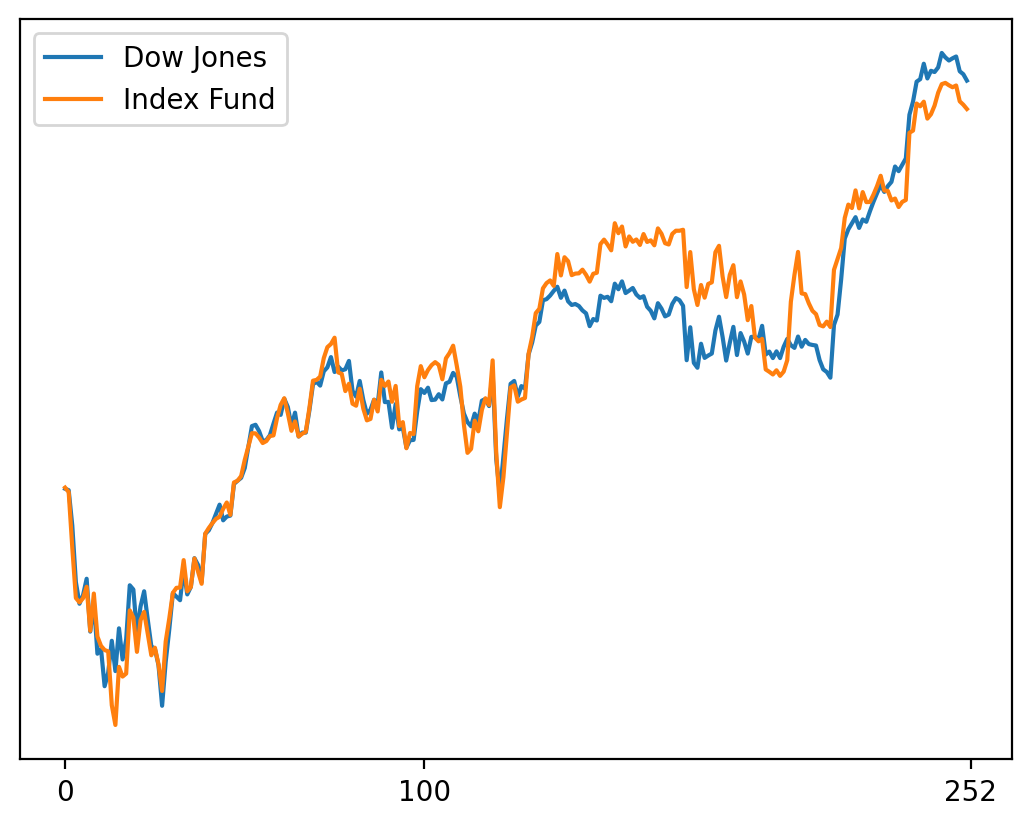

In [16]:
fig, ax = plt.subplots()
trainingDays = int(trainingdays.records['value'])
index.records.plot(y="value", ax=ax, xticks=[0, trainingDays, len(date.records)], yticks=[], label="Dow Jones")
fund.records.plot(y="value", ax=ax, xticks=[0, trainingDays, len(date.records)], yticks=[], label="Index Fund")

<Axes: ylabel='Frequency'>

<Axes: ylabel='Frequency'>

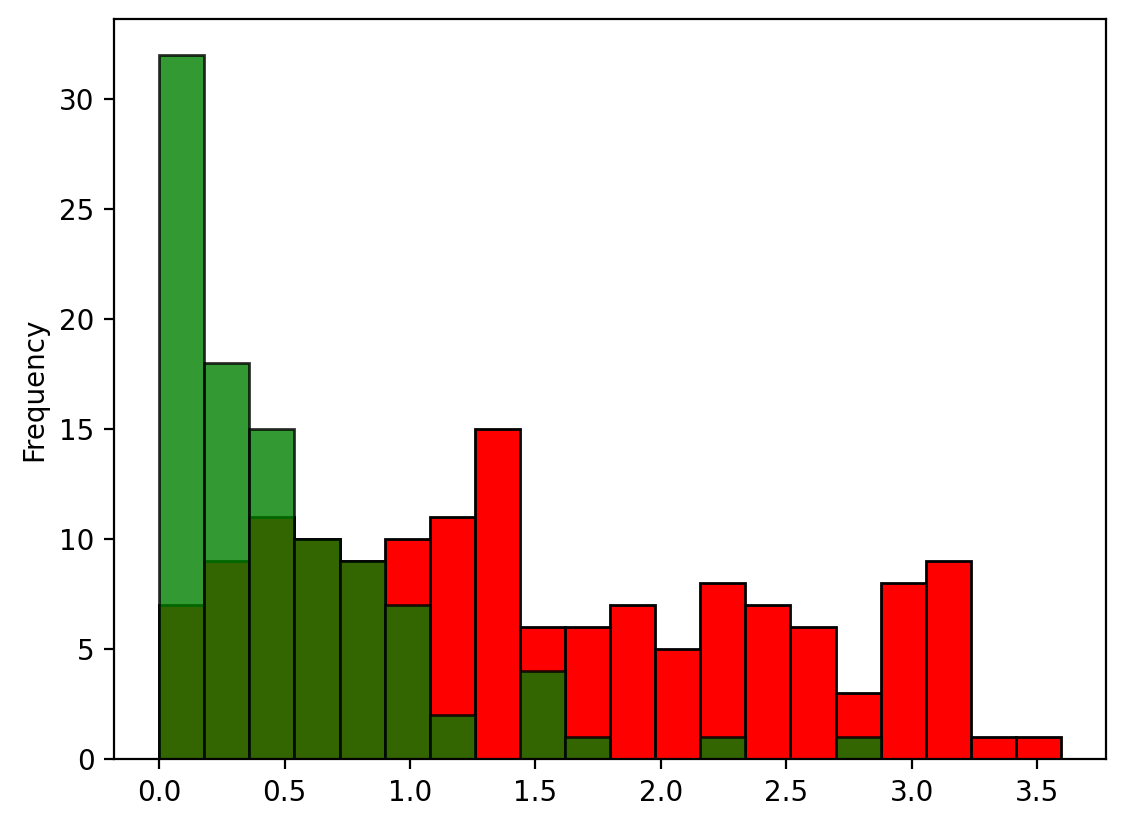

In [17]:
maxError = error.records['value'].max()
fig, ax = plt.subplots(edgecolor='black')
error.records['value'][trainingDays:].plot.hist(x='date', y='value', ax=ax, bins=20, range=(0, maxError), label='later', color='red', edgecolor='black')
error.records['value'][:trainingDays].plot.hist(x='date', y='value', ax=ax, bins=20, range=(0, maxError), label='training', color='green', alpha=0.8, edgecolor='black')

In [18]:
%gams_cleanup --closedown